In [38]:
import numpy as np, uproot as ur, awkward as ak, pandas as pd
import matplotlib.pyplot as plt
import os, sys
import pickle
import scipy.stats as st
from scipy.optimize import curve_fit


def gaus(x, amp, mean, sigma):
    return amp * np.exp( -(x - mean)**2 / (2*sigma**2) ) 


import mplhep as hep
plt.figure()
hep.style.use("CMS")
plt.close()
def configure_plotting():
    plt.rcParams['figure.facecolor'] = 'white'
    plt.rcParams['savefig.facecolor'] = 'white'
    plt.rcParams['savefig.bbox'] = None
    hep.style.use(hep.style.CMS)

In [27]:
df = pd.read_pickle('data/training/merge_single.pkl')

In [28]:
energy = df['MuographyHits.energy']
pos_theta = df['MuographyHits.theta']
pos_phi = df['MuographyHits.phi']
mc_theta = df['MCParticles.theta']
mc_phi = df['MCParticles.phi']
gnn_theta = df['GNN.theta']

Fit parameters: A=7.987, k=0.053, C=1.384


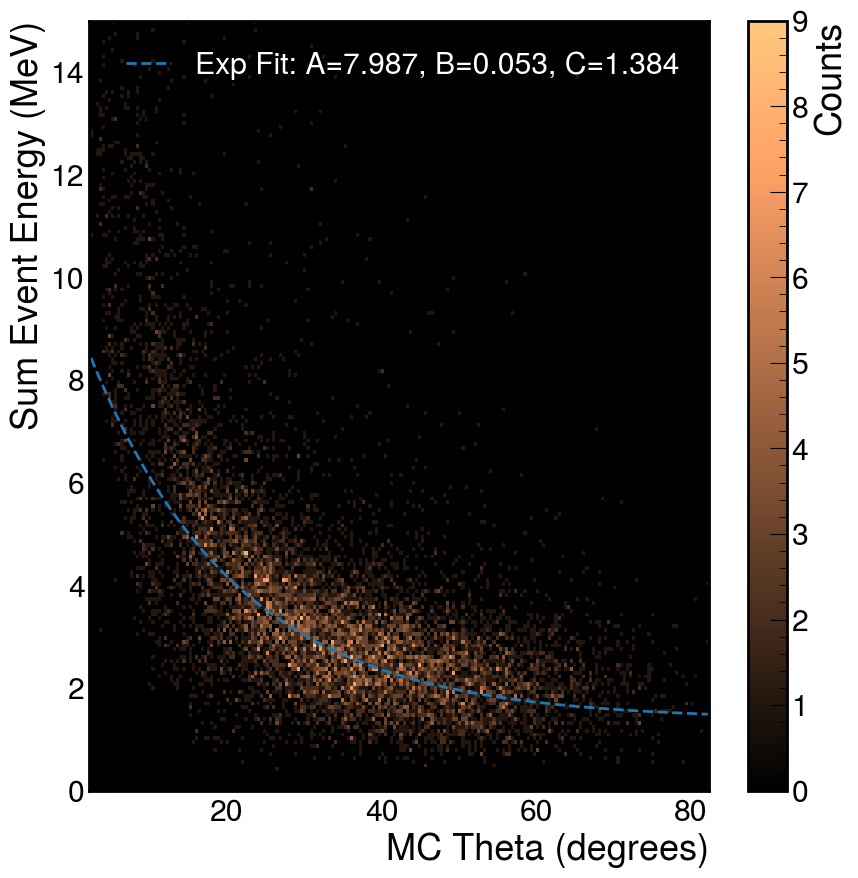

In [29]:
H, xedges, yedges = np.histogram2d(
    np.asarray(mc_theta),
    np.array(energy*1000),
    bins=(200, np.linspace(0,15,200))
)

X, Y = np.meshgrid(xedges, yedges)

plt.pcolormesh(X, Y, H.T, cmap="copper")
plt.colorbar(label='Counts')
plt.xlabel("MC Theta (degrees)")
plt.ylabel('Sum Event Energy (MeV)')
#plt.yscale('log')


peak_indices = np.argmax(H, axis=1)
theta_centers = 0.5 * (xedges[:-1] + xedges[1:])
energy_centers = 0.5 * (yedges[:-1] + yedges[1:])
E_peaks = energy_centers[peak_indices]
def exp_decay(theta, A, k, C):
    return A * np.exp(-k * theta) + C
# Remove NaNs or weird edges
mask = np.isfinite(E_peaks)
theta_fit = theta_centers[mask]
E_fit = E_peaks[mask]

popt, pcov = curve_fit(exp_decay, theta_fit, E_fit, p0=(10, 0.05, 0))
A, k, C = popt
print("Fit parameters: A=%.3f, k=%.3f, C=%.3f" % (A, k, C))
theta_smooth = np.linspace(theta_fit.min(), theta_fit.max(), 300)
plt.plot(theta_smooth, exp_decay(theta_smooth, *popt), '--', lw=2, label="Exp Fit: A=%.3f, B=%.3f, C=%.3f" % (A, k, C))
legend = plt.legend(facecolor="black", edgecolor="white")
for text in legend.get_texts():
    text.set_color("white")

In [30]:
energy = df['MuographyHits.energy']
pos_theta = df['MuographyHits.theta']
pos_phi = df['MuographyHits.phi']
mc_theta = df['MCParticles.theta']
mc_phi = df['MCParticles.phi']
gnn_theta = df['GNN.theta']

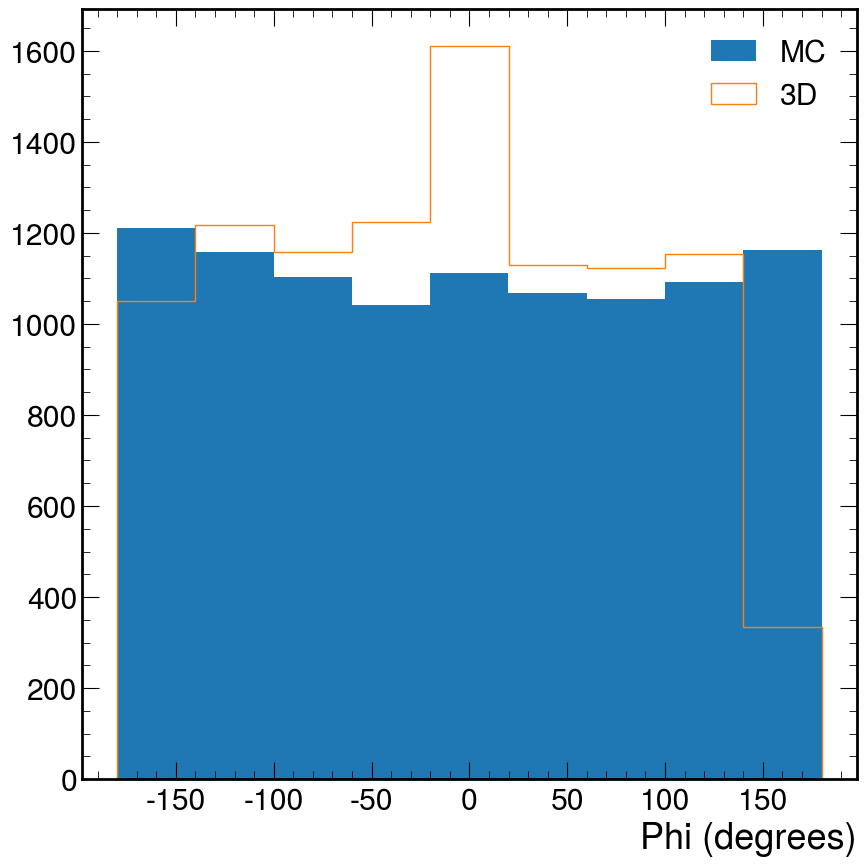

In [31]:
plt.hist(mc_phi,label='MC',bins=9)
plt.hist(pos_phi,label='3D',histtype='step',bins=9)
plt.xlabel('Phi (degrees)')
plt.legend()

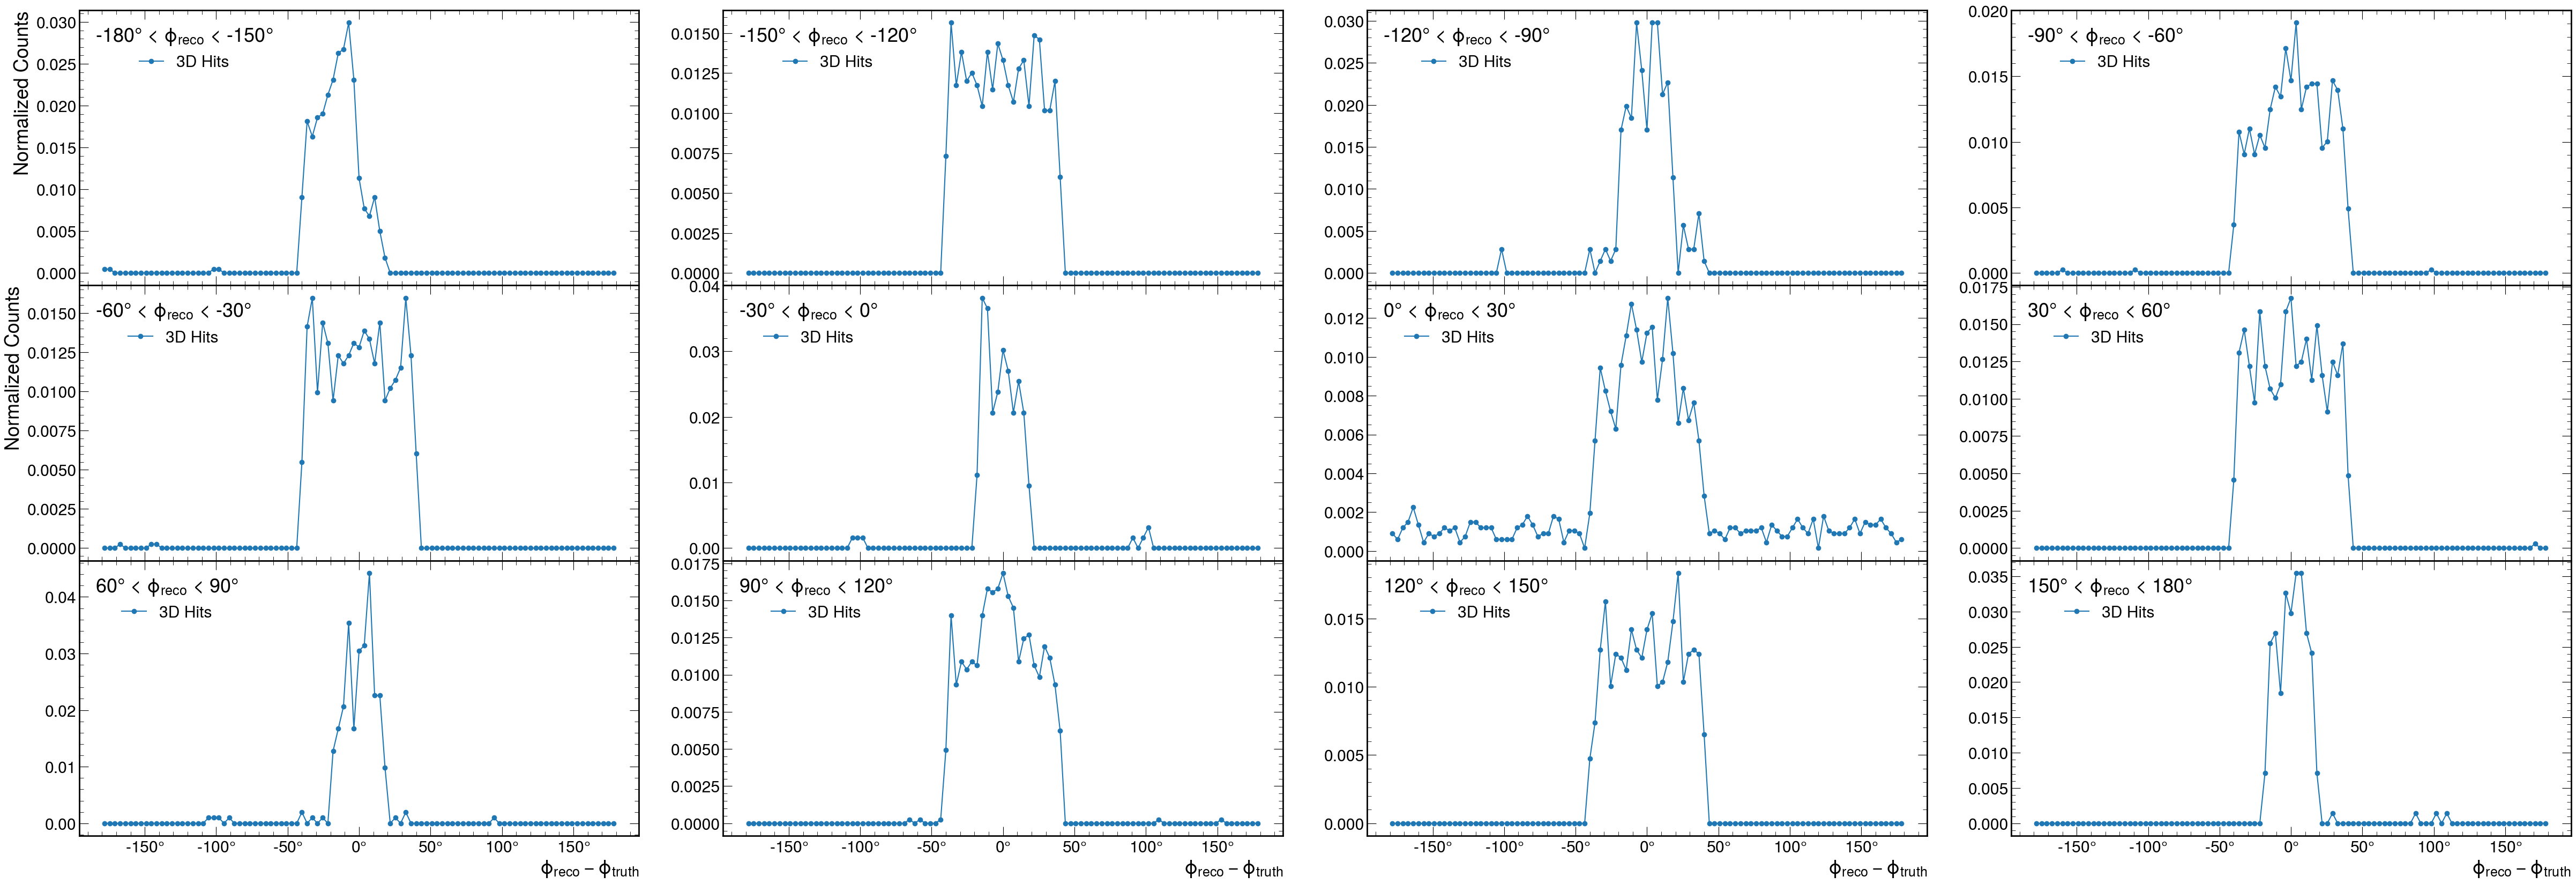

In [32]:
def theta_from_energy(E, A, k, C):
    return -(1.0 / k) * np.log((E - C) / A)
    
binsize = 30
bin = []
rms = []
mea = []
fits = []
binnum = np.linspace(-180,180,100)
max_bin = 65
fig, ax = plt.subplots(3,4,figsize=(60,20),sharex=True,sharey=False)
#plt.suptitle('Square Offset 4x16 Detector',fontsize=60)
for i in range(12):
    plt.sca(ax[i//4,i%4])
    bin.append(i*binsize+5+binsize/2)
    cut = (((i) * binsize-180 <= pos_phi) & (pos_phi < (i+1) * binsize-180))
    y,x = np.histogram(pos_phi[cut]-mc_phi[cut],bins=binnum,density=True)
    bc=(x[1:]+x[:-1])/2
    plt.errorbar(bc,y, fmt='-o',label='3D Hits')
    means = np.array(pos_theta[cut]-mc_theta[cut])
    rms.append(np.std(means))
    mea.append(np.mean(means))
    #coeff, _ = curve_fit(gaus,np.array(bc),np.array(y),p0=(0.1,0,100))
    #fits.append(coeff)
    #x=np.linspace(-50,50,100)
    #plt.errorbar(x,gaus(x,*coeff),fmt='--',label='3D Hits Fit')
    '''
    y,x = np.histogram(theta_from_energy(energy*1000,*popt)[cut]-mc_theta[cut],bins=binnum,range=(-50,50),density=True)
    bc=(x[1:]+x[:-1])/2
    plt.errorbar(bc,y, fmt='-o',label=rf'Energy')
    means = np.array(theta_from_energy(energy*1000,*popt)[cut]-mc_theta[cut])
    rms.append(np.nanstd(means))
    mea.append(np.nanmean(means))
    coeff, _ = curve_fit(gaus,np.array(bc),np.array(y),p0=(0.1,0,10))
    fits.append(coeff)
    #x=np.linspace(-50,50,100)
    #plt.errorbar(x,gaus(x,*coeff),fmt='--',label='Energy Fit')

    y,x = np.histogram(gnn_theta[cut]-mc_theta[cut],bins=binnum,range=(-50,50),density=True)
    bc=(x[1:]+x[:-1])/2
    plt.errorbar(bc,y, fmt='-o',label=rf'GNN')
    means = np.array(gnn_theta[cut]-mc_theta[cut])
    rms.append(np.std(means))
    mea.append(np.mean(means))
    coeff, _ = curve_fit(gaus,np.array(bc),np.array(y),p0=(0.05,0,20))
    fits.append(coeff)
    x=np.linspace(-50,50,100)
    plt.errorbar(x,gaus(x,*coeff),fmt='--',label='GNN Fit')
    '''
    plt.xlabel(r'$\phi_{reco} - \phi_{truth}$')
    plt.legend(title=rf'{i * binsize-180}$\degree$ < $\phi_{{reco}}$ < {(i+1) * binsize-180}$\degree$', loc = 'upper left')
    #plt.xlim(-50,50)
fig.subplots_adjust(wspace=0.15,hspace=0)

ax[0,0].set_ylabel('Normalized Counts')
ax[1,0].set_ylabel('Normalized Counts')
#ax[2,0].set_ylabel('Normalized Counts')

import matplotlib.ticker as mticker
def degree_formatter(x, pos):
    return rf"{int(x)}$\degree$" 
for axi in ax.flat:
    axi.xaxis.set_major_formatter(mticker.FuncFormatter(degree_formatter))

#plt.savefig('ThetaResolution_differential.pdf',format='pdf')

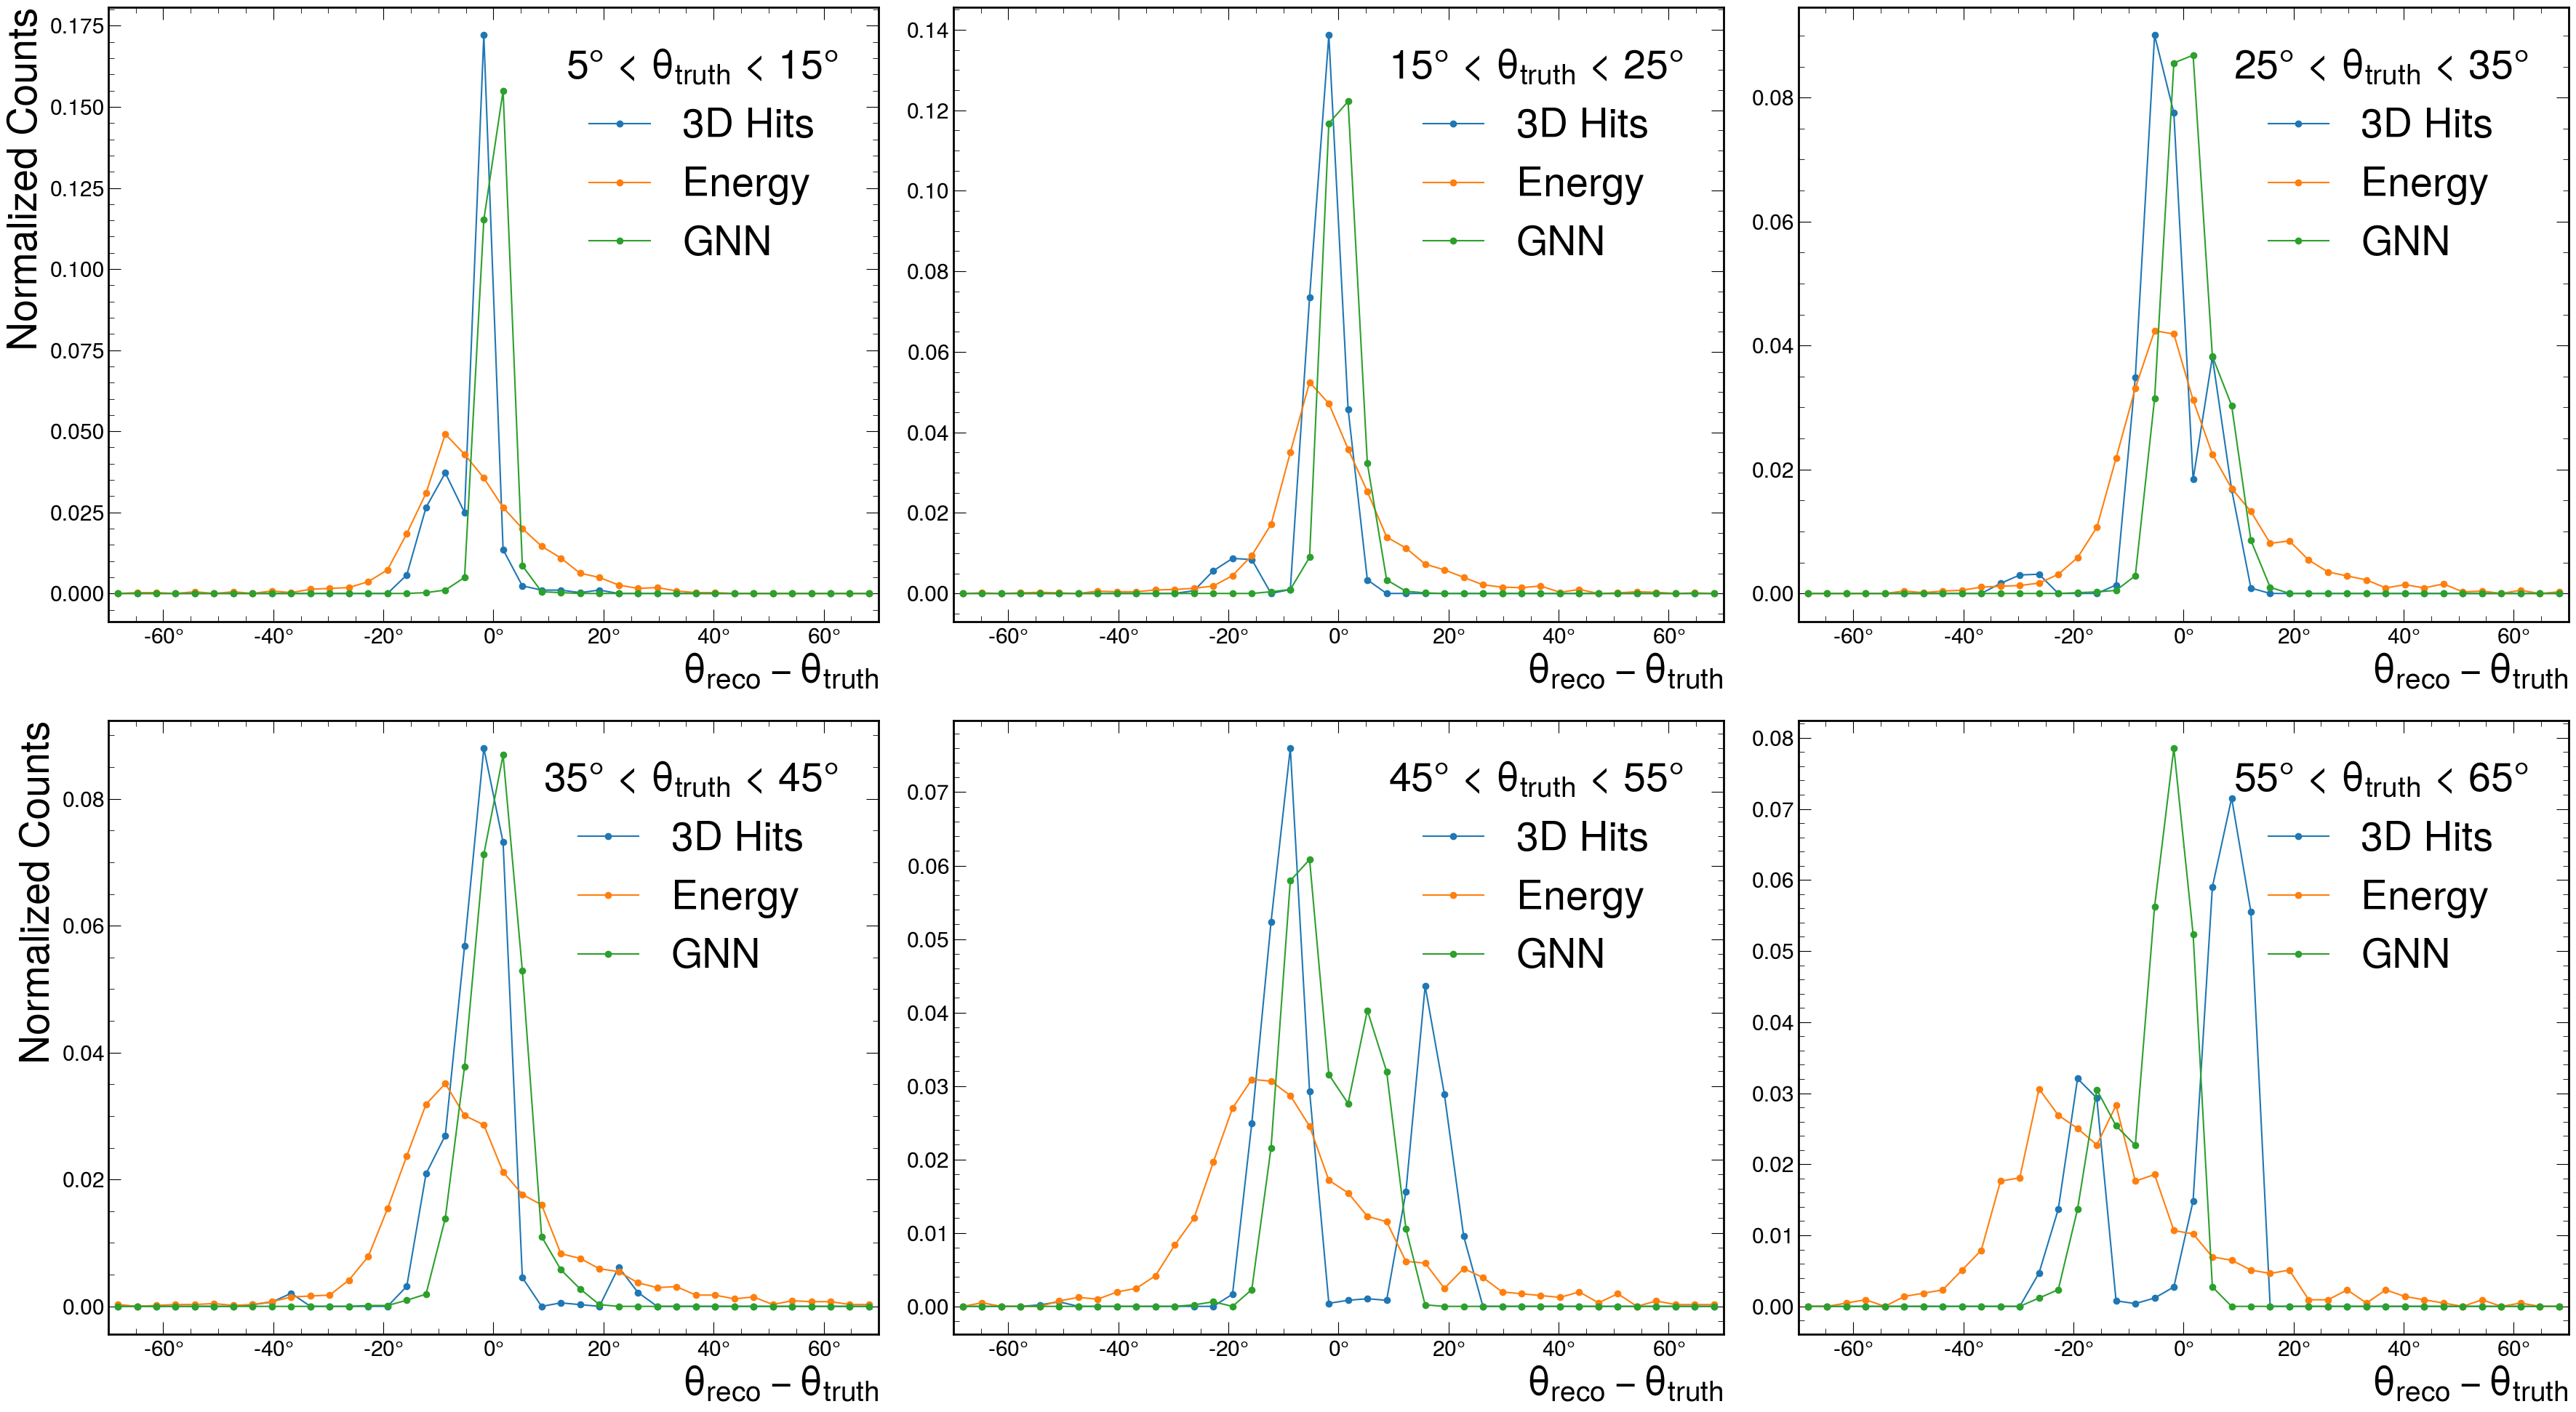

In [71]:
def theta_from_energy(E, A, k, C):
    return -(1.0 / k) * np.log((E - C) / A)
    
binsize = 10
bin = []
rms = []
mea = []
fits = []
binnum = 40
max_bin = 65
fig, ax = plt.subplots(2,3,figsize=(36,20),sharex=False,sharey=False)
#plt.suptitle('Square Offset 4x16 Detector',fontsize=60)
for i in range(6):
    plt.sca(ax[i//3,i%3])
    bin.append(i*binsize+5+binsize/2)
    cut = (((i) * binsize + 5 <= mc_theta) & (mc_theta < (i+1) * binsize + 5))
    y,x = np.histogram(pos_theta[cut]-mc_theta[cut],bins=binnum,range=(-70,70),density=True)
    bc=(x[1:]+x[:-1])/2
    plt.errorbar(bc,y, fmt='-o',label='3D Hits')
    means = np.array(pos_theta[cut]-mc_theta[cut])
    rms.append(np.std(means))
    mea.append(np.mean(means))
    coeff, _ = curve_fit(gaus,np.array(bc),np.array(y),p0=(0.1,0,100),sigma=1/y)
    fits.append(coeff)
    x=np.linspace(-50,50,100)
    #plt.errorbar(x,gaus(x,*coeff),fmt='--',label='3D Hits Fit')
    
    y,x = np.histogram(theta_from_energy(energy*1000,*popt)[cut]-mc_theta[cut],bins=binnum,range=(-70,70),density=True)
    bc=(x[1:]+x[:-1])/2
    plt.errorbar(bc,y, fmt='-o',label=rf'Energy')
    means = np.array(theta_from_energy(energy*1000,*popt)[cut]-mc_theta[cut])
    rms.append(np.nanstd(means))
    mea.append(np.nanmean(means))
    coeff, _ = curve_fit(gaus,np.array(bc),np.array(y),p0=(0.1,0,10))
    fits.append(coeff)
    #x=np.linspace(-50,50,100)
    #plt.errorbar(x,gaus(x,*coeff),fmt='--',label='Energy Fit')

    y,x = np.histogram(gnn_theta[cut]-mc_theta[cut],bins=binnum,range=(-70,70),density=True)
    bc=(x[1:]+x[:-1])/2
    plt.errorbar(bc,y, fmt='-o',label=rf'GNN')
    means = np.array(gnn_theta[cut]-mc_theta[cut])
    rms.append(np.std(means))
    mea.append(np.mean(means))
    coeff, _ = curve_fit(gaus,np.array(bc),np.array(y),p0=(0.05,0,30))
    fits.append(coeff)
    x=np.linspace(-70,70,100)
    #plt.errorbar(x,gaus(x,*coeff),fmt='--',label='GNN Fit')

    plt.xlabel(r'$\theta_{reco} - \theta_{truth}$',fontsize=40)
    plt.legend(title=rf'{i * binsize+5}$\degree$ < $\theta_{{truth}}$ < {(i+1) * binsize+5}$\degree$', loc = 'upper right',fontsize=40,title_fontsize=40)
    plt.xlim(-70,70)
fig.subplots_adjust(wspace=0.15,hspace=0)

ax[0,0].set_ylabel('Normalized Counts',fontsize=40)
ax[1,0].set_ylabel('Normalized Counts',fontsize=40)
#ax[2,0].set_ylabel('Normalized Counts')

import matplotlib.ticker as mticker
def degree_formatter(x, pos):
    return rf"{int(x)}$\degree$" 
for axi in ax.flat:
    axi.xaxis.set_major_formatter(mticker.FuncFormatter(degree_formatter))
plt.tight_layout()
plt.savefig('ThetaResolution_differential.png',format='png')

/home/jiajun/.local/lib/python3.8/site-packages/awkward/_nplikes/array_module.py:251: RuntimeWarning: invalid value encountered in log
  return impl(*broadcasted_args, **(kwargs or {}))


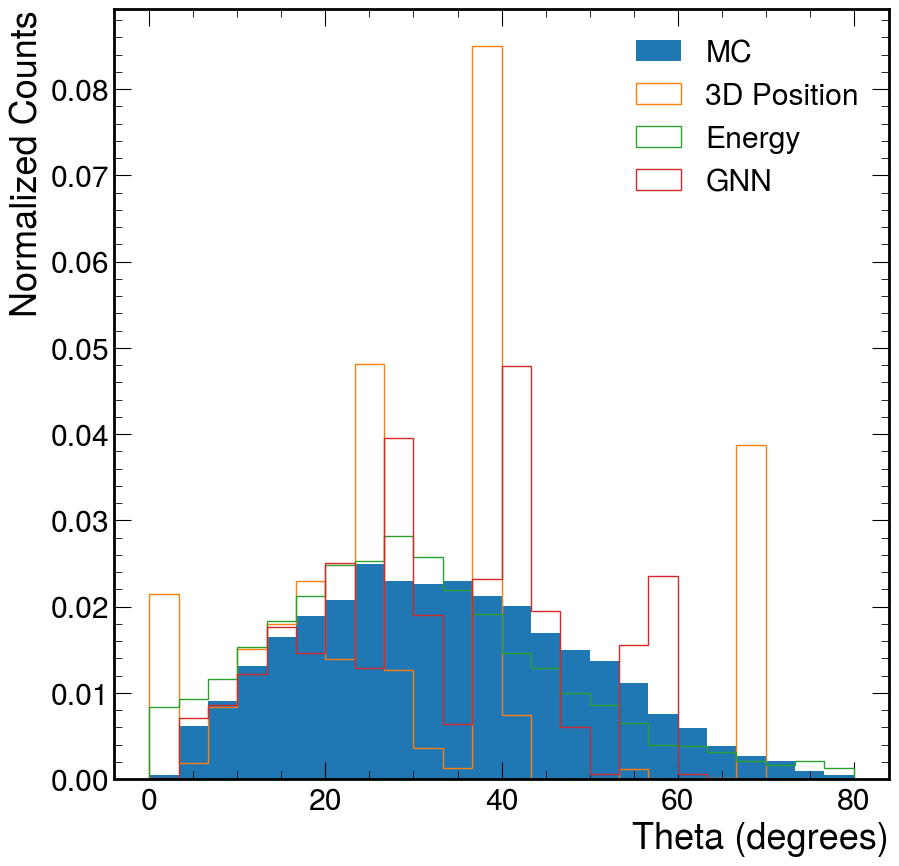

In [39]:
configure_plotting()
bin = np.linspace(0,80,25)#np.logspace(1,1.8,15)
plt.hist(mc_theta,label='MC',bins=bin,density=True)
plt.hist(pos_theta,label='3D Position',histtype='step',bins=bin,density=True)

plt.hist(theta_from_energy(energy*1000,*popt),label='Energy',histtype='step',bins=bin,density=True)

plt.hist(gnn_theta,label='GNN',histtype='step',bins=bin,density=True)
plt.xlabel('Theta (degrees)')
plt.ylabel('Normalized Counts')
plt.legend()

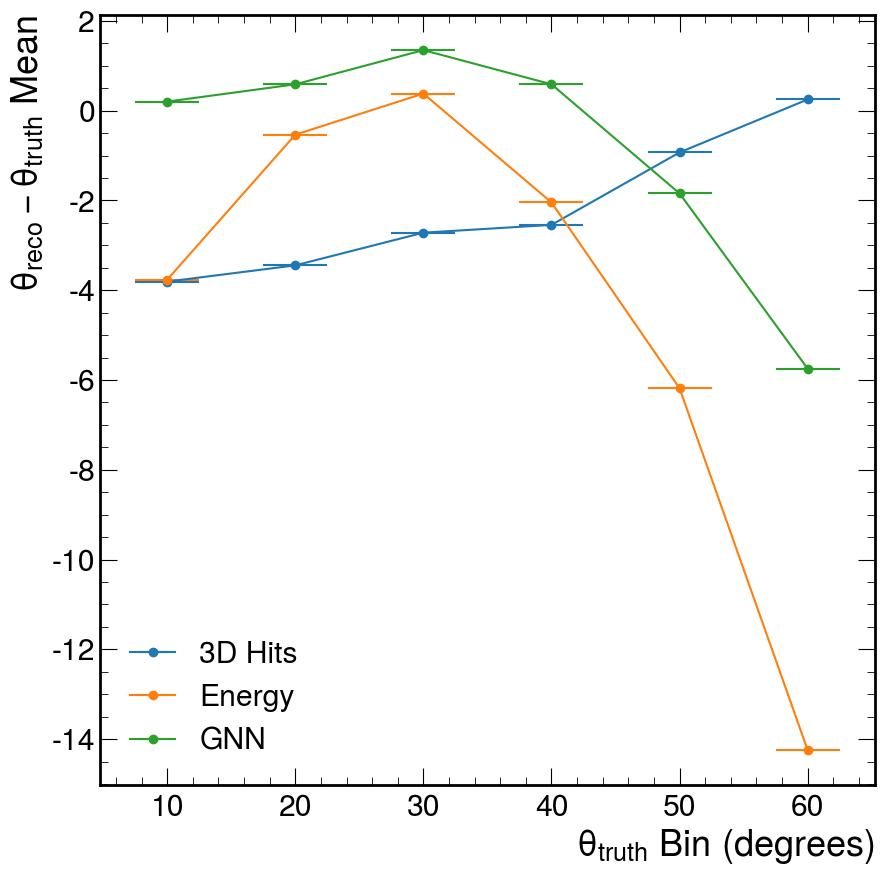

In [44]:
configure_plotting()
plt.errorbar(bin,mea[::3],xerr=(bin[1]-bin[0])/4,label='3D Hits',fmt='-o')
plt.errorbar(bin,mea[1::3],xerr=(bin[1]-bin[0])/4,label='Energy',fmt='-o')
plt.errorbar(bin,mea[2::3],xerr=(bin[1]-bin[0])/4,label='GNN',fmt='-o')
plt.xlabel(rf'$\theta_{{truth}}$ Bin (degrees)')
plt.ylabel(r'$\theta_{reco} - \theta_{truth}$ Mean')
plt.legend()

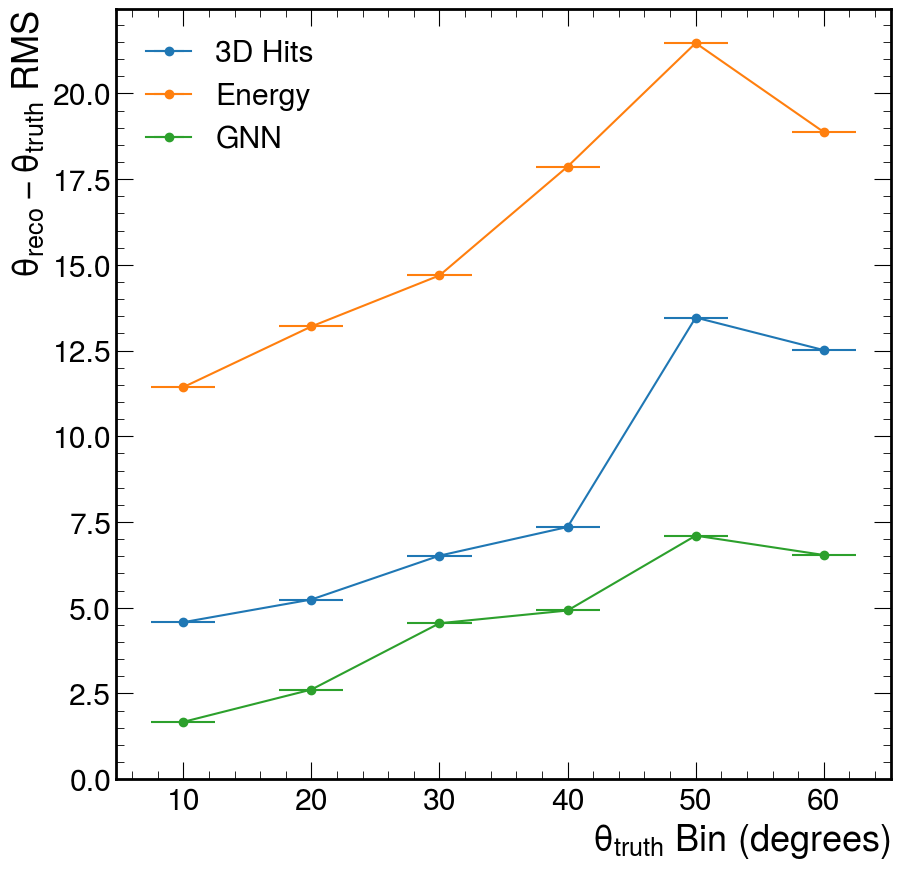

In [45]:
plt.errorbar(bin,rms[::3],xerr=(bin[1]-bin[0])/4,label='3D Hits',fmt='-o')
plt.errorbar(bin,rms[1::3],xerr=(bin[1]-bin[0])/4,label='Energy',fmt='-o')
plt.errorbar(bin,rms[2::3],xerr=(bin[1]-bin[0])/4,label='GNN',fmt='-o')
plt.xlabel(rf'$\theta_{{truth}}$ Bin (degrees)')
plt.ylabel(r'$\theta_{reco} - \theta_{truth}$ RMS')
plt.ylim(bottom=0)
plt.legend()

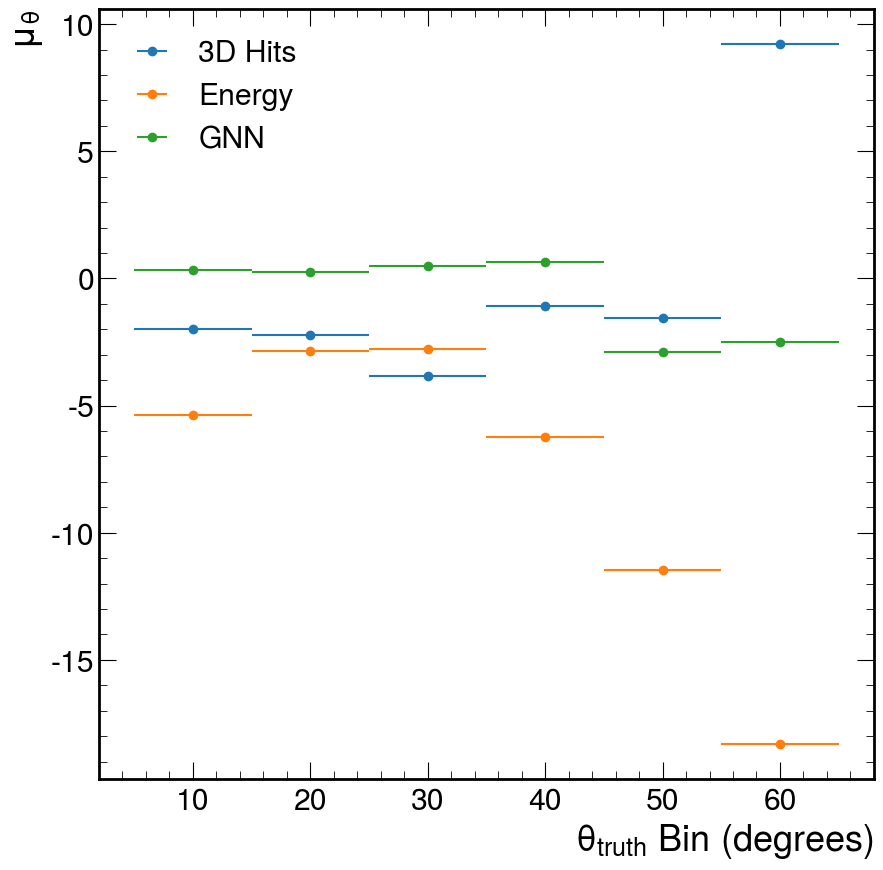

In [65]:
configure_plotting()
plt.errorbar(bin,np.array(fits)[:,1][::3],xerr=(bin[1]-bin[0])/2,label='3D Hits',fmt='o')
plt.errorbar(bin,np.array(fits)[:,1][1::3],xerr=(bin[1]-bin[0])/2,label='Energy',fmt='o')
plt.errorbar(bin,np.array(fits)[:,1][2::3],xerr=(bin[1]-bin[0])/2,label='GNN',fmt='o')
plt.xlabel(rf'$\theta_{{truth}}$ Bin (degrees)')
plt.ylabel(r'$\mu_{\theta}$')
#plt.ylim(bottom=0)
plt.legend()
plt.savefig('ThetaResolution_mu.png',format='png')

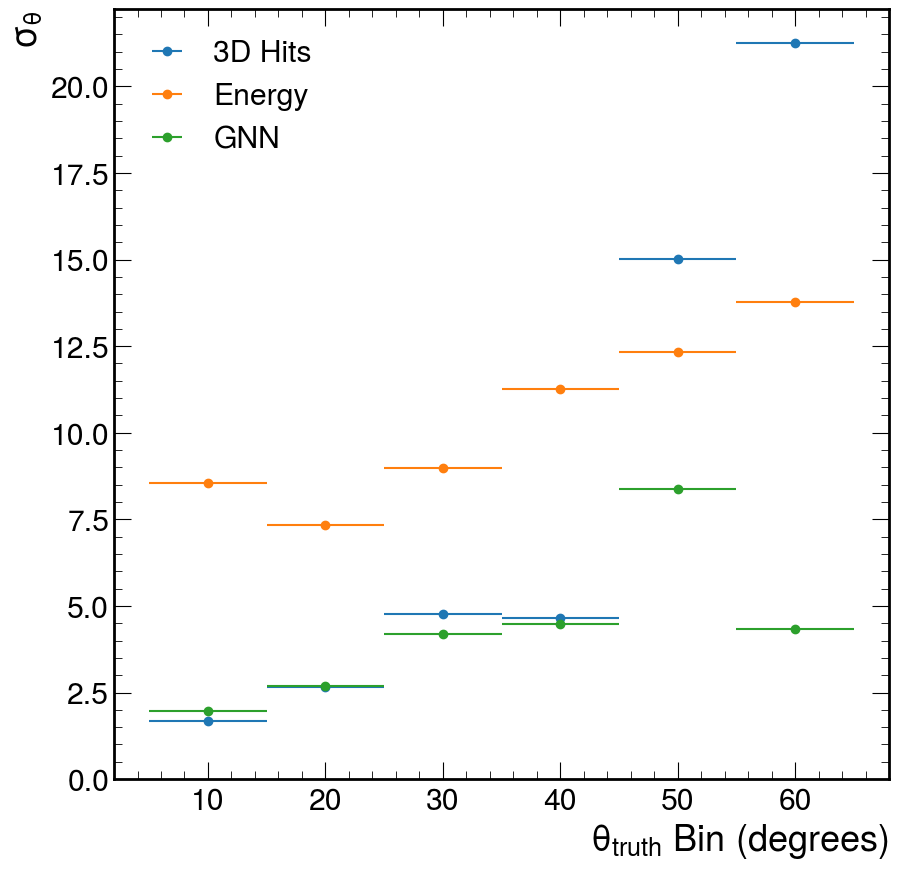

In [66]:
configure_plotting()
plt.errorbar(bin,abs(np.array(fits)[:,2][::3]),xerr=(bin[1]-bin[0])/2,label='3D Hits',fmt='o')
plt.errorbar(bin,abs(np.array(fits)[:,2][1::3]),xerr=(bin[1]-bin[0])/2,label='Energy',fmt='o')
plt.errorbar(bin,abs(np.array(fits)[:,2][2::3]),xerr=(bin[1]-bin[0])/2,label='GNN',fmt='o')
plt.xlabel(rf'$\theta_{{truth}}$ Bin (degrees)')
plt.ylabel(r'$\sigma_{\theta}$')
plt.ylim(bottom=0)
plt.legend()
plt.savefig('ThetaResolution_sigma.png',format='png')

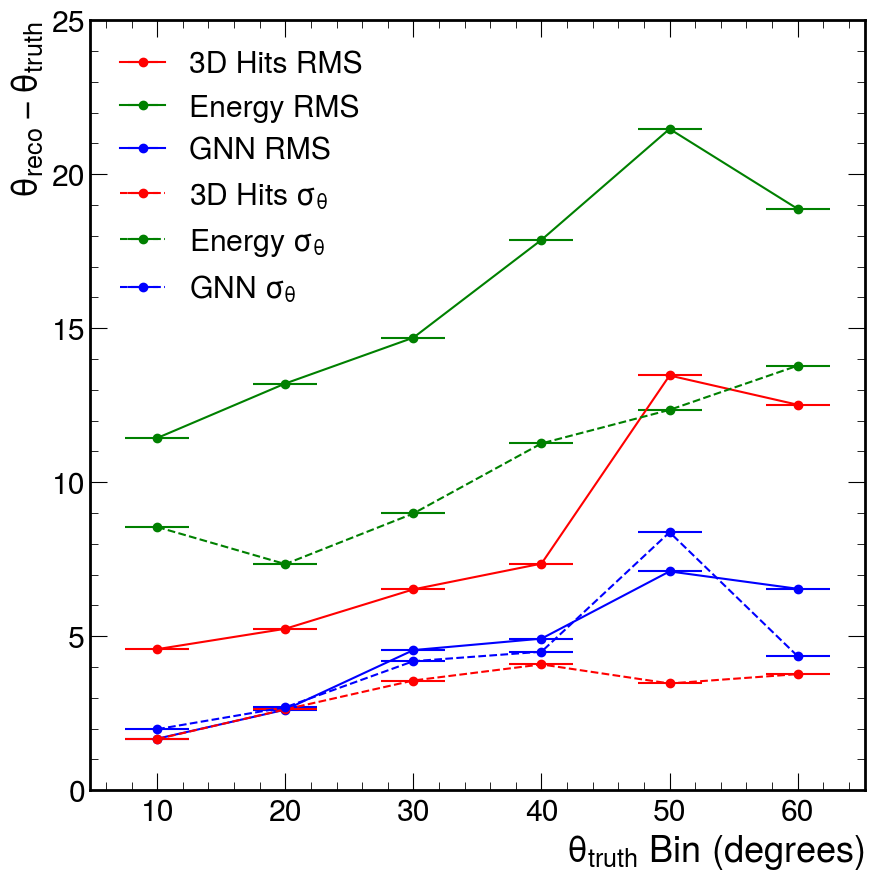

In [48]:
configure_plotting()
plt.errorbar(bin,rms[::3],xerr=(bin[1]-bin[0])/4,label='3D Hits RMS',fmt='-o',c='r')
plt.errorbar(bin,rms[1::3],xerr=(bin[1]-bin[0])/4,label='Energy RMS',fmt='-o',c='g')
plt.errorbar(bin,rms[2::3],xerr=(bin[1]-bin[0])/4,label='GNN RMS',fmt='-o',c='b')
plt.errorbar(bin,abs(np.array(fits)[:,2][::3]),xerr=(bin[1]-bin[0])/4,label=r'3D Hits $\sigma_{\theta}$',fmt='--o',c='r')
plt.errorbar(bin,abs(np.array(fits)[:,2][1::3]),xerr=(bin[1]-bin[0])/4,label=r'Energy $\sigma_{\theta}$',fmt='--o',c='g')
plt.errorbar(bin,abs(np.array(fits)[:,2][2::3]),xerr=(bin[1]-bin[0])/4,label=r'GNN $\sigma_{\theta}$',fmt='--o',c='b')
plt.xlabel(rf'$\theta_{{truth}}$ Bin (degrees)')
plt.ylabel(r'$\theta_{reco} - \theta_{truth}$')
plt.ylim(bottom=0,top=25)
plt.legend()
